## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\CGANs


## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [3]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [4]:
asset_names = returns_df.columns

In [5]:
from internal_models.utilities.generate_quarterly_scenarios import generate_quarterly_scenarios

## TRAINING CGAN

In [6]:
from cgan1 import CGAN1

for asset_name in returns_df.columns:
    print(f"Training CGAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    # Create WGAN instance for the current asset
    gan = CGAN1(asset_returns, asset_name)
    
    # Train WGAN for this asset
    gan.train()
    #gan.generate_scenarios(num_scenarios=20000)
    generate_quarterly_scenarios(gan, test_returns_df, asset_name, num_scenarios_per_condition=10000)
    
    print(f"Finished training CGAN for {asset_name}.\n")

Training CGAN for REEL...
[Epoch 0/3000] [Batch 0/16] [D loss: -0.1307] [G loss: 0.1461]
[Epoch 0/3000] [Batch 10/16] [D loss: -0.0617] [G loss: 0.0757]
[Epoch 1/3000] [Batch 0/16] [D loss: 0.0392] [G loss: 0.0867]
[Epoch 1/3000] [Batch 10/16] [D loss: 0.1480] [G loss: 0.1646]
[Epoch 2/3000] [Batch 0/16] [D loss: 0.0806] [G loss: 0.0720]
[Epoch 2/3000] [Batch 10/16] [D loss: -0.2777] [G loss: -0.0067]
[Epoch 3/3000] [Batch 0/16] [D loss: 0.0137] [G loss: 0.1115]
[Epoch 3/3000] [Batch 10/16] [D loss: 0.0615] [G loss: -0.0003]
[Epoch 4/3000] [Batch 0/16] [D loss: 0.0494] [G loss: 0.1045]
[Epoch 4/3000] [Batch 10/16] [D loss: 0.0520] [G loss: 0.0574]
[Epoch 5/3000] [Batch 0/16] [D loss: 0.0069] [G loss: 0.2726]
[Epoch 5/3000] [Batch 10/16] [D loss: 0.1398] [G loss: 0.1692]
[Epoch 6/3000] [Batch 0/16] [D loss: 0.0692] [G loss: 0.1844]
[Epoch 6/3000] [Batch 10/16] [D loss: -0.0644] [G loss: 0.3071]
[Epoch 7/3000] [Batch 0/16] [D loss: 0.0846] [G loss: 0.1095]
[Epoch 7/3000] [Batch 10/16] [D

## RESULTS

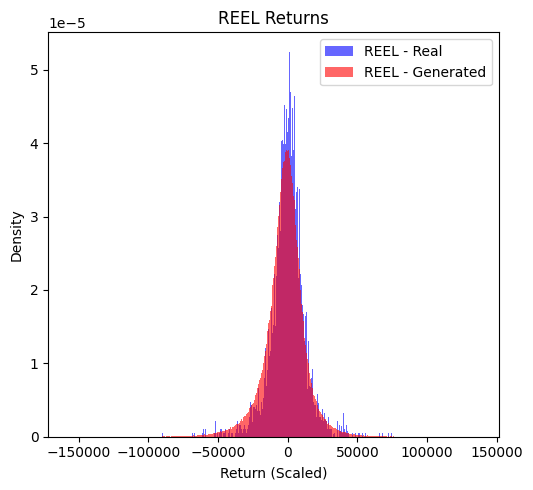


📊 Return Statistics Summary:
           Asset         Mean      Std Dev  Skewness  Kurtosis     99.5% VaR
     REEL - Real   193.261827 12915.831965 -0.270455  4.969021 -51644.473240
REEL - Generated -1908.042969 14606.819336 -0.471506  4.448308 -55452.640625



═══════════════════════════
║  ANALYZING ASSET: REEL  ║
═══════════════════════════

Variance of Real Data: 0.000167
Variance of Generated Data: 0.000180
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.276380
Mean Pairwise Distance (Generated): 0.281614
✅ Generated samples are reasonably diverse


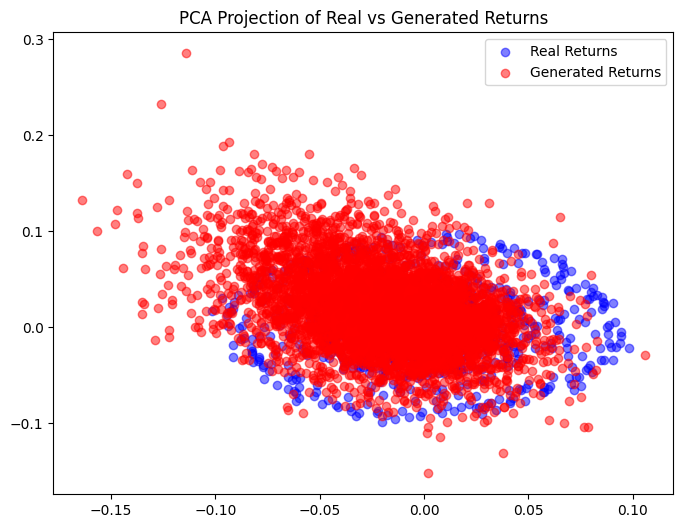

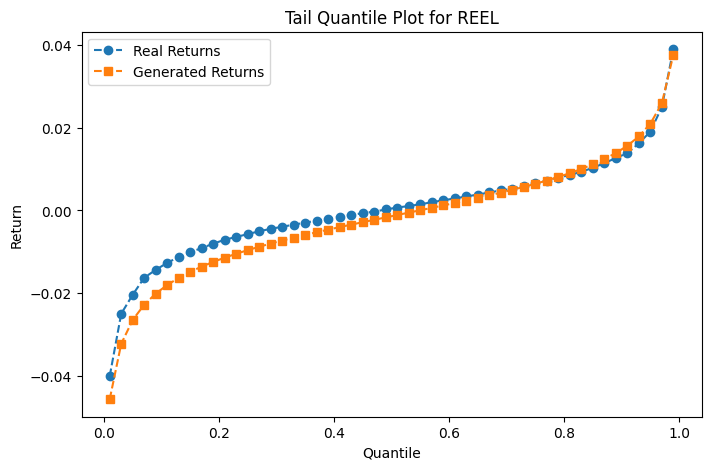


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════


📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 8.275767
Mean Distance: 0.002153
Median Distance: 0.000323
Standard Deviation: 0.035229


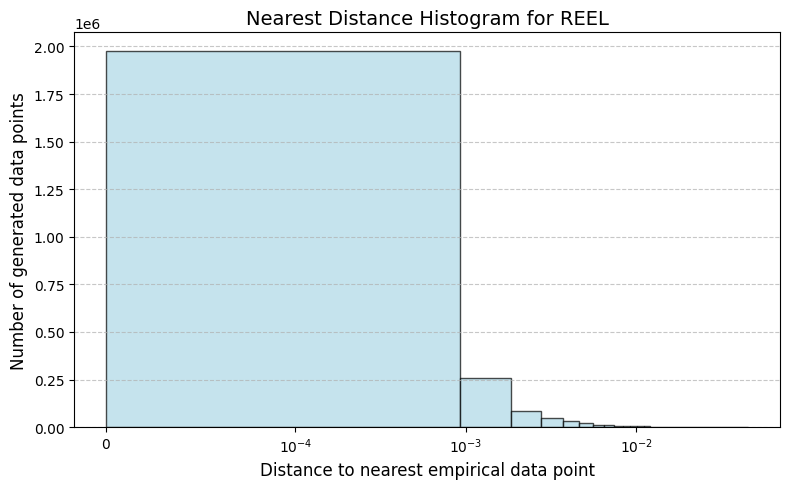


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

📊 Wasserstein Distance for REEL: 0.002586



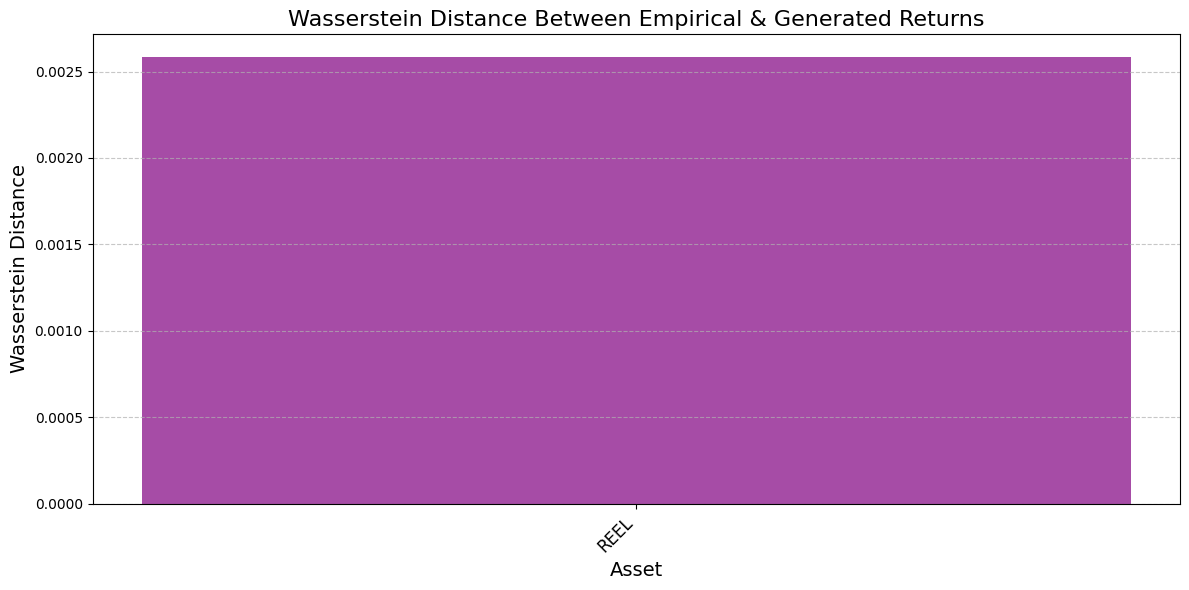

In [10]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=True)

In [8]:
from utilities.load_generated_quarters import load_all_generated_quarters

all var thresholds [np.float32(-0.05459043), np.float32(-0.05405632), np.float32(-0.054150317), np.float32(-0.05435027)]


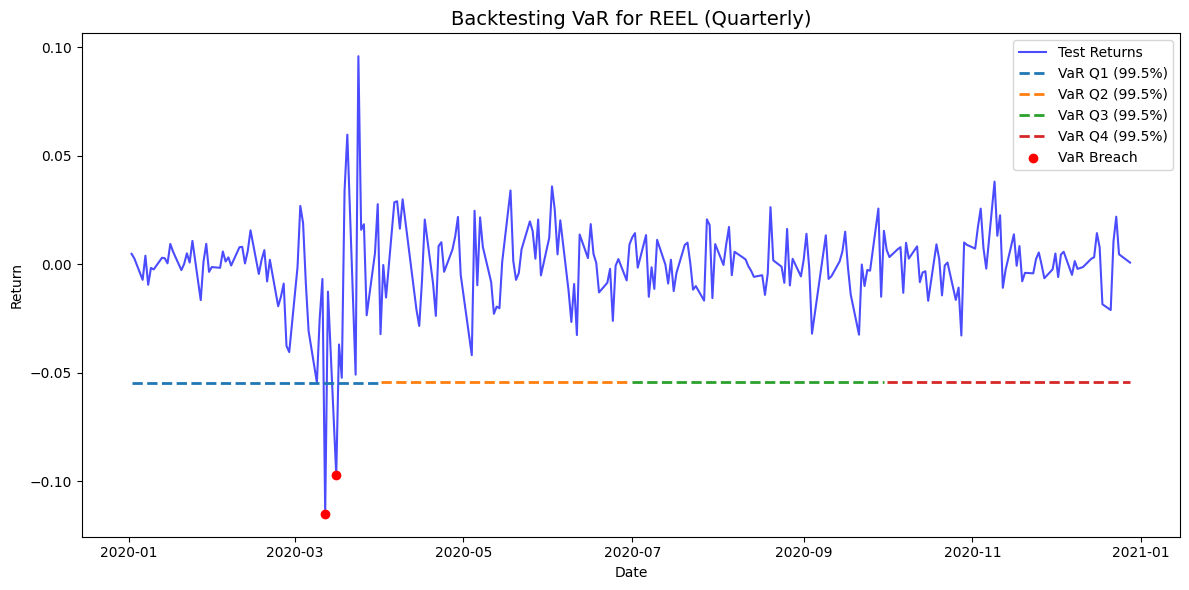


📊 VaR Backtesting Results for REEL

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 0.3703
📊 p-value: 0.542826
🚦 Test Conclusion: ✅ Passed (p > 0.1) - No significant failure pattern detected 🎉

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 23.2972
📊 p-value: 0.000001
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 23.6675
📊 p-value: 0.000007
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.015197
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.015197
🚦 A higher value is worse.

Distribution Tests for REEL
Overall Moments Comparison:
Generated -> Mean: -0.0018, Std: 0.0152, Skewness: -0.2316
Empirical -> Mean: 0.0002, Std: 0.0129, Skewness: -0.2705

Skewness Test on Generated Data:
Test Statistic: -148.1575
p-value: 0.0000
Skewn

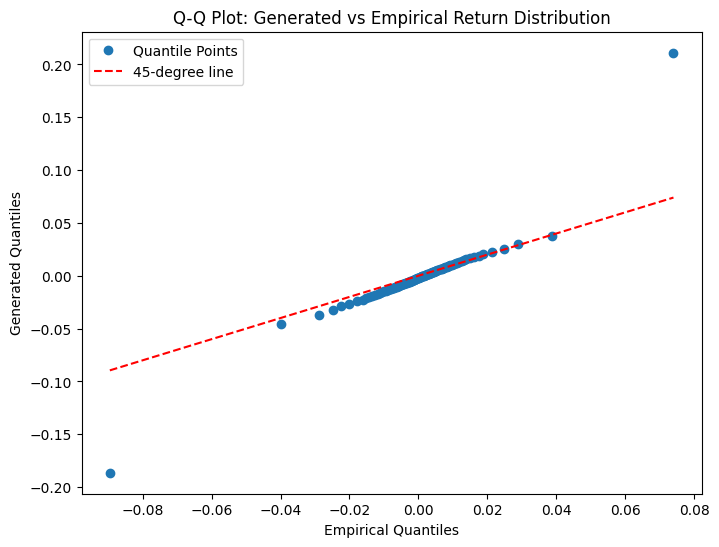


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 4.348245
Overall Mean Empirical Excess Kurtosis: 4.969059015521381
Difference (Generated - Empirical): -0.6208138716310003
Interpretation: The generated distribution's tail heaviness is close to the empirical benchmark.


In [9]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)
